# <center>پروژه درس سیگنال ها و سیستم ها</center>
<h3><center>استاد: دکترمیناسادات محمودی<br>امیررضا قدیانی<br>99109206 شماره دانشجویی<br>1402-2</center></h3>

<div dir="rtl">

1. پروژه خود را تا تاریخ ۲۹ تیرماه ۱۴۰۲ از طریق کوئرا تحویل دهید.
2. اصولا مشورت دانشجویان در حل تمرین‌ها و پروژه نه تنها نکوهیده نیست، بلکه شدیدا توصیه می‌شود اما خواهشمندیم رونویسی صورت نگیرد.
3. سعی کنید کد های خود را در محل مناسب در این notebook بنویسید، توصیه می شود برای فهم بهتر مصحح کامنت گذاری حداقلی(فارسی یا انگلیسی) انجام دهید.
4. بهترین منابع در اختیار شما صفحات Discrete cosine transform و JPEG در ویکیپدیا هستند. در صورت ابهام به آنها رجوع کنید.(در صورت پروژه نیز به آنها ارجاع داده شده است.)
5. سوالات خود را از طریق کوئرا مطرح کنید تا دستیاران پروژه به آنها پاسخ دهند و بقیه نیز از سوال و جواب ها بهره ببرند.

</div>

## <center> بخش اول پروژه <br>پیاده سازی فشرده سازی JPEG</center>

<div dir="rtl">

فرض کنید می خواهید عکسی را فشرده سازی کنید. برای این کار ابتدا پارامتر هایی را حذف یا کمرنگ می کنید که چشم انسان نسبت به آن‌ها کمتر حساس است. اگر تصویری را به مولفه های فرکانسی آن خرد کنیم، چشم انسان کمتر به فرکانس های بالا دقت می کند. پس با حذف این فرکانس ها می توان حجم تصویر را کم کرد و این ایده مخترعین فرمت JPEG است. اکنون از شما می خواهیم که قدم به قدم یک عکس را فشرده سازی کنید و دوباره آن را به حالت اولیه باز گردانید. برای راحتی، فرض می کنیم عکس ورودی سیاه و سفید است.<br>
   <img src="https://www.researchgate.net/profile/Jacinta-Oshea-2/publication/7232959/figure/fig2/AS:282593288310787@1444386898429/High-and-low-spatial-frequency-information-Images-contain-different-spatial-frequencies_W640.jpg" alt="Drawing" style="width: 600px;"/>
    <center>در تصویر سمت چپ عکس اصلی قرار داده شده است، در تصویر وسط فقط فرکانس های پایین و در تصویر سمت راست فقط فرکانس های بالا حضور دارند.<br>فرکانس هایی پایین شمای کلی تصویر و فرکانس های بالا لبه ها و جزئیات را در بر دارند.</center>

</div>

<div dir="rtl">

### گام صفر: کتابخانه ها<br>
کتابخانه های لازم برای پروژه در زیر آمده است
اگر نیاز به کتابخانه دیگری دارید آن را اضافه کنید و دلیل نیاز خود را توضیح دهید.

</div>

In [23]:
import numpy as np
import cv2 as cv  #install using pip: "pip install opencv-python"
import matplotlib.pyplot as plt
import seaborn as sns  #install using pip: "pip install seaborn"

<div dir="rtl">

### گام اول: خواندن عکس<br>
در این گام با استفاده از cv2 عکس مورد نظر را می خوانیم. چون تصویر را به صورت خاکستری یا grayscale باز می کنیم، تصویر یک آرایه دو بعدی خواهد بود که هر مولفه آن نشان دهنده روشنایی یک پیکسل است.

</div>

(910, 910)


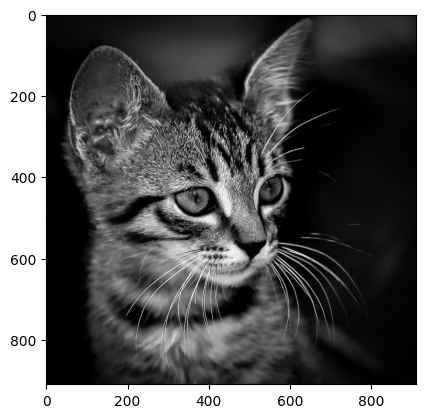

In [24]:
image_path = 'cat.jpg'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
print(image.shape)  #height, width
plt.imshow(image, cmap='gray')
plt.show()

<div dir="rtl">

### گام دوم: خرد کردن عکس به قطعه های 8x8<br>
لازم است که عکس را به قطعات 8x8 تقسیم کنیم و در هر یک از این قطعات مولفه های فرکانسی طولی و عرضی را استخراج کنیم و تصمیم بگیریم کدام یک را حذف کنیم. پس تابعی بنویسید که با گرفتن عکس، مربع های 8x8 آن را به صورت لیست(به ترتیب از 0,0 تا خانه آخر) خروجی دهد. طول و عرض عکس بر 8 بخش پذیر نبود، بقیه خانه ها را صفر فرض کنید.

</div>

In [25]:
def extract_squares(image):
    height, width = image.shape
    dh = 0
    dw = 0
    img_slices = []

    if height % 8 != 0:
        dh = (height // 8) * 8 - (height - 8)

    if width % 8 != 0:
        dw = (width // 8) * 8 - (width - 8)

    image = np.concatenate((image, np.zeros((dh, image.shape[1]))), axis=0)
    image = np.concatenate((image, np.zeros((image.shape[0], dw))), axis=1)

    for i in range(image.shape[0] // 8):
        for j in range(image.shape[1] // 8):
            h_i = i * 8
            h_j = j * 8
            img_slices.append(image[h_i:h_i + 8, h_j:h_j + 8])
    img_slices_array = np.array(img_slices)
    return img_slices_array


<div dir="rtl">

### گام سوم: Discrete Cosine Transform<br>
اکنون می خواهیم برای استخراج مولفه های فرکانسی مربع های 8x8 خود از DCT استفاده کنیم. ابتدا تابعی بنویسید که DCT-II را روی یک سیگنال یک بعدی اجرا کند. رابطه زیر ضرایب تبدیل کسینوسی را به شما می دهد.([ویکیپدیا](https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II))<br>
$${\displaystyle X_{k}=\sum _{n=0}^{N-1}x_{n}\cos \left[\,{\tfrac {\,\pi \,}{N}}\left(n+{\tfrac {1}{2}}\right)k\,\right]\qquad {\text{ for }}~k=0,\ \dots \ N-1~.}$$

</div>

In [26]:
def dct_1d(signal):
    N = len(signal)
    signal_transformed = []
    for k in range(0, N):
        x_k = 0
        for n in range(0, N):
            temp = np.cos((np.pi * k * (n + 0.5)) / N)
            x_k += signal[n] * temp
        signal_transformed.append(x_k)

    dct1 = np.array(signal_transformed)
    return dct1

<div dir="rtl">

### گام چهارم: تبدیل روی ماتریس<br>
برای گرفتن DCT روی ماتریس 8x8 ابتدا از همه ی اعداد ماتریس خود 128 واحد کم کنید. اینگونه بازه ی اعداد شما از ${(0,255)}$ به ${(-128,127)}$ تغییر می کند و مقدار ثابت آن حذف می شود. سپس برای DCT دو بعدی یکبار روی طول و یکبار روی عرض تابع خود DCT را پیاده کنید. می توانید این کار را با تابع `np.apply_along_axis` انجام دهید.<br>
 <img src="https://upload.wikimedia.org/wikipedia/commons/2/24/DCT-8x8.png"/>
    <center>در بالا تابع dct-II را به صورت دو بعدی می بینید. گرادیان روشنایی به تاریکی نشان دهنده میزان تابع از مثبت یک تا منفی یک است.</center>
<br>
علاوه بر روشی که ما اجرا کردیم می توان با ماتریس ضرب ماتریسی نیز DCT را پیاده کرد. برای این کار نیاز به ماتریس تبدیل مثل ${C}$ داریم. آنگاه با استفاده از رابطه زیر DCT محاسبه می شود.([جزئیات بیشتر](https://fairyonice.github.io/2D-DCT.html))
    $${X = C x C^{T}}$$
</div>

In [27]:
def dct_2d(matrix):
    matrix_temp = matrix.copy()
    matrix_temp -= 128
    temp1 = np.apply_along_axis(dct_1d, 0, matrix_temp)
    temp2 = np.apply_along_axis(dct_1d, 1, temp1)
    return temp2

<div dir="rtl">

### گام پنجم: Quantization<br>
حالا که ضرایب را به دست آورده ایم، می خواهیم آنهایی را که اهمیت کمتری دارند را حذف کنیم. برای اینکار از یک ماتریس Quantization استفاده می کنیم. این ماتریس به ما نشان می دهد که تا چه حد می توانیم ضرایب بدرد نخور را دور بریزیم.([ویکیپدیا](https://en.wikipedia.org/wiki/JPEG#Quantization))<br>
در زیر این ماتریس برای کیفیت های 10، 50 و 90 به شما داده شده است. برای فشرده سازی لازم است که اعضای ماتریس بدست آمده از DCT را بر اعضای متناظر خود در ماتریس Quantization تقسیم کنیم و عدد بدست آمده را گرد کنیم.

</div>

In [28]:
quality_levels = {
    10: np.array([[80, 60, 50, 80, 120, 200, 255, 255],
                  [55, 60, 70, 95, 130, 255, 255, 255],
                  [70, 65, 80, 120, 200, 255, 255, 255],
                  [70, 85, 110, 145, 255, 255, 255, 255],
                  [90, 110, 185, 255, 255, 255, 255, 255],
                  [120, 175, 255, 255, 255, 255, 255, 255],
                  [245, 255, 255, 255, 255, 255, 255, 255],
                  [255, 255, 255, 255, 255, 255, 255, 255]]),

    50: np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                  [12, 12, 14, 19, 26, 58, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]]),

    90: np.array([[3, 2, 2, 3, 5, 8, 10, 12],
                  [2, 2, 3, 4, 5, 12, 12, 11],
                  [3, 3, 3, 5, 8, 11, 14, 11],
                  [3, 3, 4, 6, 10, 17, 16, 12],
                  [4, 4, 7, 11, 14, 22, 21, 15],
                  [5, 7, 11, 13, 16, 12, 23, 18],
                  [10, 13, 16, 17, 21, 24, 24, 21],
                  [14, 18, 19, 20, 22, 20, 20, 20]])
}

In [29]:
def quantization(matrix, q_matrix):
    matrix_div = np.divide(matrix, q_matrix)
    return matrix_div.astype(int)

<div dir="rtl">

### گام ششم: حذف عناصر اضافه<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/43/JPEG_ZigZag.svg" alt="Drawing" style="width: 400px;"/>

در این مرحله ماتریس بدست آمده از مرحله قبل را به صورت زیگ زاگ(مانند شکل بالا) می خوانیم. با این کار باید یک دنباله به طول 64 بدست بیاوریم. اکنون از آخرین عدد غیر صفر دنباله به بعد را حذف می کنیم. بعد از آن دنباله را می نویسیم(بین دو عدد متوالی ویرگول می گذاریم) و هر جایی که صفر دیدیم نمی نویسیم.(که طول رشته مان کمتر شود.)<br>
مثالی برای ورودی و خروجی یک ماتریس 4x4 در زیر آورده شده است.

</div>

In [30]:
# input
#[  1,   5,   23,   0,
#  12, 119,    7,   0,
#   6,   0,    0,   0,
#   0,   8,    0,   0]
# sequence
# [1,5,12,6,119,23,0,7,0,0,8,0,0,0,0,0]
# removing last zeros
# [1,5,12,6,119,23,0,7,0,0,8]
# removing zeros in the middle and returning a string
# "1,5,12,6,119,23,,7,,,8"


def matrix_to_string(matrix):
    arranged_matrix = matrix_iteration(matrix)
    zero_handle(arranged_matrix)
    result_str = str(arranged_matrix)
    result_str = white_space_handle(result_str)
    result_str = str_handle(result_str)
    return result_str


def matrix_iteration(matrix):
    result = []
    iter_len = matrix.shape[0]
    full_iter = 2 * iter_len - 1
    for i in range(full_iter):
        if i <= iter_len - 1:
            less_iterlen_part(i, matrix, result)
        else:
            more_iterlen_part(i, iter_len, matrix, result)

    return result


def more_iterlen_part(i, iter_len, matrix, result):
    step = 2 * (iter_len - 1) - i
    if i % 2 == 1:
        for j in range(iter_len - 1, iter_len - 2 - step, -1):
            result.append(matrix[i - j][j])
    else:
        for j in range(iter_len - 1, iter_len - 2 - step, -1):
            result.append(matrix[j][i - j])


def less_iterlen_part(i, matrix, result):
    if i % 2 == 1:
        for j in range(i + 1):
            result.append(matrix[j][i - j])
    else:
        for j in range(i, -1, -1):
            result.append(matrix[j, i - j])


def zero_handle(arranged_matrix):
    while len(arranged_matrix) > 0:
        if arranged_matrix[-1] == 0:
            del arranged_matrix[-1]
        else:
            break


def str_handle(result_str):
    result_str = result_str.replace('0', '')
    result_str = result_str.replace('[', '')
    result_str = result_str.replace(']', '')
    return result_str


def white_space_handle(result_str):
    result_str = result_str.replace(' ', '')
    return result_str

<div dir="rtl">

### گام هفتم: پیاده سازی compression<br>
در این مرحله باید همه کار هایی که قبلا توابعی را که قبلا نوشتید را پشت سر هم استفاده کنید تا در نهایت بتوانیم یک عکس را فشرده سازی کنیم. در ذخیره فایل، ضریب کیفیت و طول و عرض تصویر را بنویسید که برای decompress کردن آن لازم مان می شود.

</div>

In [31]:
def jpeg_comp(input_image_path, output_file_path, quality):
    image = cv.imread(input_image_path, cv.IMREAD_GRAYSCALE)
    height, width = image.shape
    section_strings = []
    squares = extract_squares(image)

    for matrix in squares:
        dct2 = dct_2d(matrix)
        qn = quality_levels[quality]
        q = quantization(dct2, qn)
        section_strings.append(matrix_to_string(q))

    file = open(output_file_path, 'w')
    head_str = f'{height} {width}\n {quality}\n'
    file.write(head_str)

    for str in section_strings:
        write_str = str + '\n'
        file.write(write_str)

    file.close()

<div dir="rtl">

#### نکته<br>
امروزه در فشرده سازی JPEG، دو مرحله دیگر نیز طی می شود:<br>
مرحله اول: در صورتی که تعدادی از اعداد یا نماد های دنباله ما تکراری باشد، تعداد تکرار های آن ضرب در نماد را به جای نماد می گذاریم. مثلا اگر در دنباله خود داشته باشیم
    $${1,1,1,1}$$
به جای آن می نویسیم:
    $${4\times 1}$$<br>
مرحله دوم: از huffman coding استفاده می کنیم. یعنی زیر رشته هایی که بیشتر تکرار می شوند را به رشته های کوتاه تر و آنهایی که کمتر تکرار می شوند را رشته های بلند تر map می کنیم. با این کار طول کل رشته مان کم می شود. در آخر نیز این map خود را به فایل اضافه می کنیم تا دوباره بتوانیم رشته تولید شده توسط huffman coding را به رشته اولیه باز گردانیم.([ویکیپدیا](https://en.wikipedia.org/wiki/Huffman_coding))<br>
اما از آنجایی که درس شما در مورد الگوریتم های فشرده سازی نیست این دو بخش از پروژه شما حذف شده اند.
</div>

<div dir="rtl">

اکنون کافی است که همه گام ها را برعکس طی کنیم تا به تصویر اصلی برسیم. اگر تا اینجای پروژه را انجام دادید این بخش سخت نخواهد بود.

</div>

<div dir="rtl">

### گام هشتم(برعکس شش): تبدیل رشته به ماتریس<br>
با گرفتن یک رشته ماتریس 8x8 متناظر آن را بسازید.

</div>

In [32]:
def string_to_matrix(string):
    recreate_matrix = []
    number_array = string.split(',')
    arrange_numbers(number_array, recreate_matrix)
    add_end_zeros(recreate_matrix)
    final_result = matrix_arrange(recreate_matrix)
    return final_result


def matrix_arrange(numbers):
    result_matrix = np.zeros((8, 8))
    locate_number = 0
    for i in range(2 * 8 - 1):
        if i <= 7:
            locate_number = less_part_handle(i, locate_number, numbers, result_matrix)
        else:
            locate_number = more_part_handle(i, locate_number, numbers, result_matrix)

    return result_matrix


def more_part_handle(i, locate_number, numbers, result_matrix):
    step = 2 * 7 - i
    if i % 2 == 1:
        for j in range(7, 7 - step - 1, -1):
            result_matrix[i - j][j] = numbers[locate_number]
            locate_number += 1
    else:
        for j in range(7, 7 - step - 1, -1):
            result_matrix[j][i - j] = numbers[locate_number]
            locate_number += 1
    return locate_number


def less_part_handle(i, locate_number, numbers, result_matrix):
    if i % 2 == 1:
        for j in range(i + 1):
            result_matrix[j][i - j] = numbers[locate_number]
            locate_number += 1
    else:
        for j in range(i, -1, -1):
            result_matrix[j, i - j] = numbers[locate_number]
            locate_number += 1

    return locate_number


def add_end_zeros(recreate_matrix):
    while len(recreate_matrix) < 64:
        recreate_matrix.append(0)


def arrange_numbers(number_array, recreate_matrix):
    for number in number_array:
        if number != '':
            recreate_matrix.append(int(number))
        else:
            recreate_matrix.append(0)


<div dir="rtl">

### گام نهم(برعکس پنج):Dequantization<br>
برای اینکه اثر ماتریس Quantization از بین برود، اینبار کافی است عناصر را در آن ماتریس ضرب کنیم.

</div>

In [33]:
def dequantization(matrix, q_matrix):
    result = np.multiply(matrix, q_matrix)
    return result


<div dir="rtl">

### گام دهم(برعکس سه و چهار): IDCT<br>
تبدیل کسینوسی معکوس را ابتدا یک بعدی و سپس دو بعدی بنویسید(بعد از تبدیل دوباره مقدار 128 را به آن اضافه کنید).([ویکیپدیا](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Inverse_transforms))

</div>

In [34]:
def idct_1d(signal):
    N = len(signal)
    signal_retransformed = []
    for k in range(0, N):
        x_k = 0
        for n in range(1, N):
            temp = np.cos((np.pi * n * (k + 0.5)) / N)
            x_k += signal[n] * temp
        x_k += 0.5 * signal[0]
        x_k *= 2
        x_k /= N
        signal_retransformed.append(x_k)

    result_array = np.array(signal_retransformed)
    return result_array


def idct_2d(matrix):
    temp1 = np.apply_along_axis(idct_1d, 0, matrix)
    temp2 = np.apply_along_axis(idct_1d, 1, temp1)
    temp2 += 128
    return temp2

<div dir="rtl">

### گام یازدهم(برعکس دو): ساخت عکس<br>
با در دست داشتن طول و عرض عکس و ماتریس های بدست آمده، عکس را بسازید!

</div>

In [35]:
def merge_squares(matrices, height, width):
    if height % 8 != 0:
        height = (height // 8) * 8 + 8
    if width % 8 != 0:
        width = (width // 8) * 8 + 8

    index = 0
    merged_image = np.zeros((height, width))
    for i in range(height // 8):
        for j in range(width // 8):
            h_i = i * 8
            h_j = j * 8
            merged_image[h_i:h_i + 8, h_j:h_j + 8] = matrices[index]
            index += 1

    return merged_image

<div dir="rtl">

### گام دوازدهم(برعکس هفت): پیاده سازی decompression<br>
با جمع آوری توابع در کنار یکدیگر، عکس قسمت قبلی را باز سازی کنید.

</div>

In [36]:
def jpeg_decomp(input_file_path, output_image_path):
    file = open(input_file_path, 'r')
    file_value = file.read()
    file.close()
    lines = file_value.split('\n')
    hw = lines[0].split(' ')
    height = int(hw[0])
    width = int(hw[1])
    quality = int(lines[1])
    strings = lines[2: len(lines) - 1]
    matrices = []
    for string in strings:
        m = string_to_matrix(string)
        q = quality_levels[quality]
        dq = dequantization(m, q)
        matrices.append(idct_2d(dq))

    matrices = np.array(matrices)
    final_image = merge_squares(matrices, height, width)
    final_image[final_image > 255] = 255
    final_image[final_image < 0] = 0
    cv.imwrite(output_image_path, final_image)

    return final_image

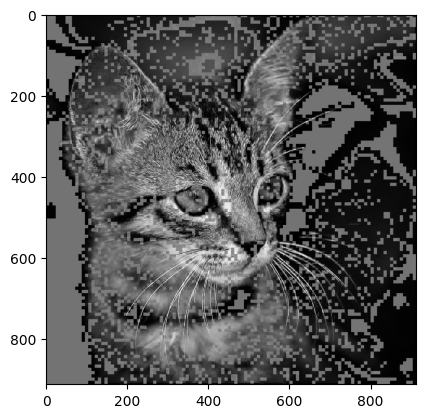

In [37]:
jpeg_comp('cat.jpg', 'compress_cat.txt', 90)
compress_cat_img = jpeg_decomp('compress_cat.txt', 'compress_cat_img.jpeg')
plt.imshow(compress_cat_img, cmap='gray')

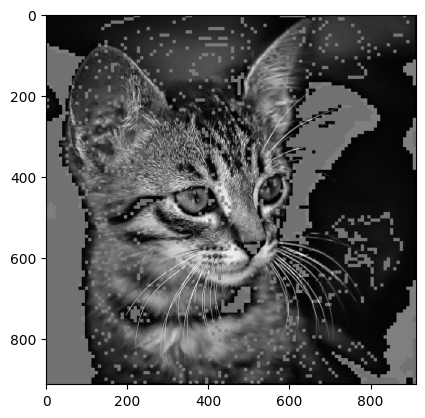

In [38]:
jpeg_comp('cat.jpg', 'compress_cat10.txt', 10)
compress_cat_img10 = jpeg_decomp('compress_cat10.txt', 'compress_cat_img10.jpeg')
plt.imshow(compress_cat_img10, cmap='gray')

<div dir="rtl">

### سوال اول:<br>
برای فهم بهتر Q-table ها، 5 مربع 8x8 تصادفی از تصویر خود انتخاب کنید. تبدیل DCT را انجام دهید و Heatmap آنها را به ترتیب رسم کنید.(برای رسم Heatmap از کتابخانه seaborn کمک بگیرید).
</div>

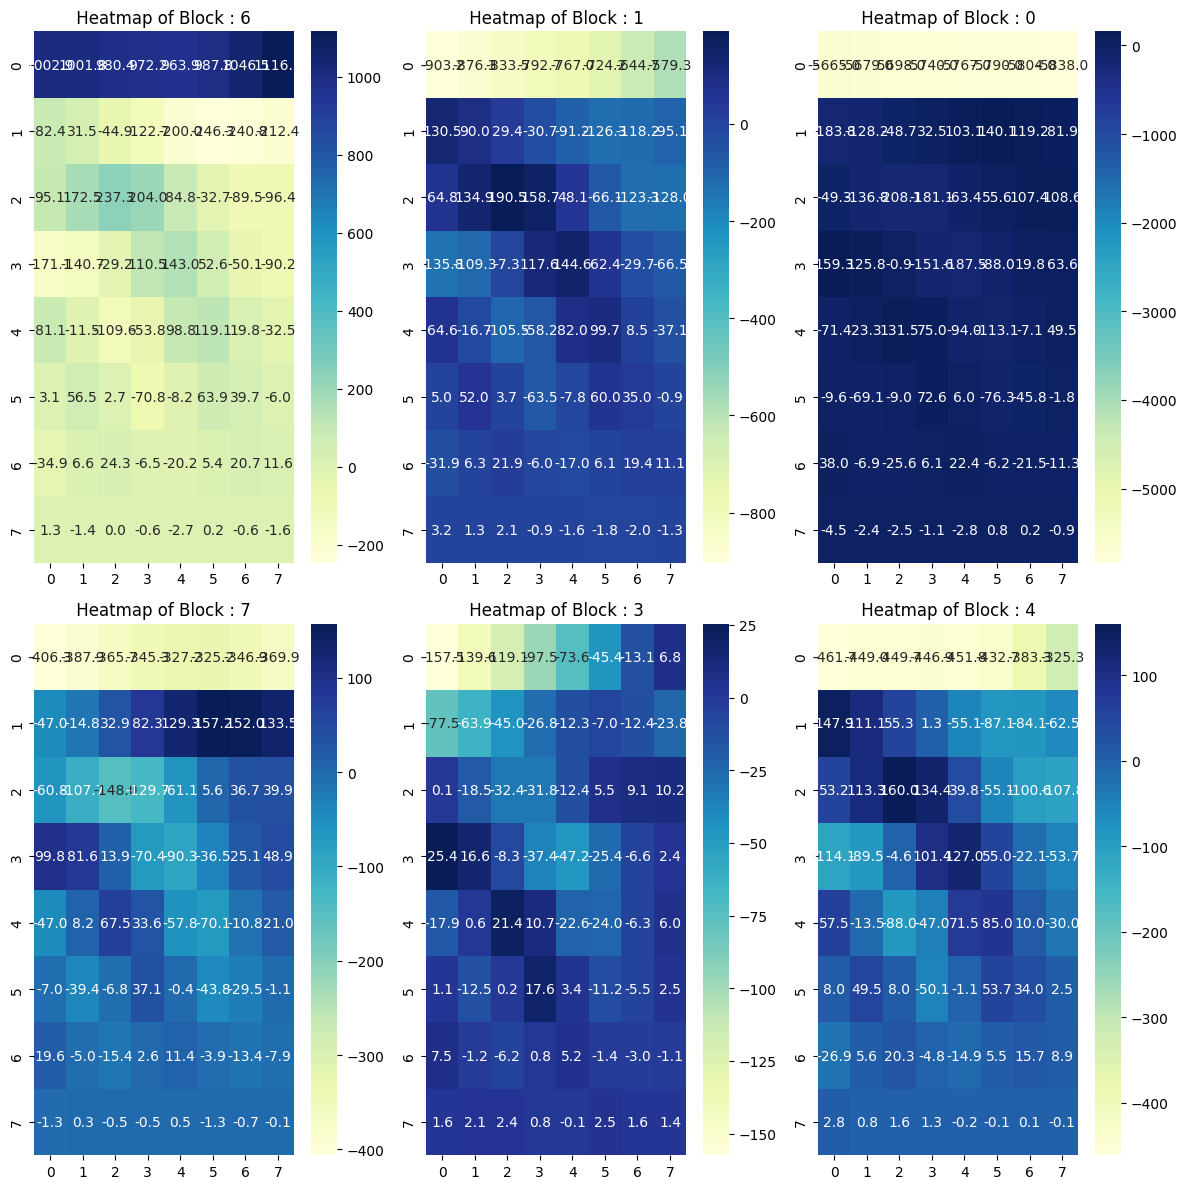

array([6, 1, 0, 7, 3, 4])

In [55]:
def random_blocks_heatmap(n, array):
    num_blocks = array.shape[0]
    indices = np.random.choice(num_blocks, n, replace=False)
    columns_iter = int(np.ceil(np.sqrt(n)))
    rows_iter = int(np.ceil(n / columns_iter))
    fig, axes = plt.subplots(rows_iter, columns_iter, figsize=(12, 12))

    k = 0
    for index in indices:
        row_index = k // columns_iter
        column_index = k % columns_iter
        block = array[index]
        sns.heatmap(block, cmap='YlGnBu', ax=axes[row_index, column_index], cbar=True, annot=True, fmt=".1f")
        axes[row_index, column_index].set_title(f" Heatmap of Block : {index} ")
        k += 1

    fig.tight_layout()
    plt.show()

    return indices


squares = extract_squares(image)
indices = np.random.choice(list(range(len(squares))), 8, replace=False)
chosen_list = list()
for index in indices:
    chosen_list.append(squares[index])

chosen = np.array(chosen_list)
chosen_dct = dct_2d(chosen)
random_blocks_heatmap(6, chosen_dct)

<div dir="rtl">
اکنون به ترتیب Quantization و Dequantization را روی هر کدام با کیفیت 90 انجام دهید و در زیر Heatmap آنها را رسم کنید.
</div>

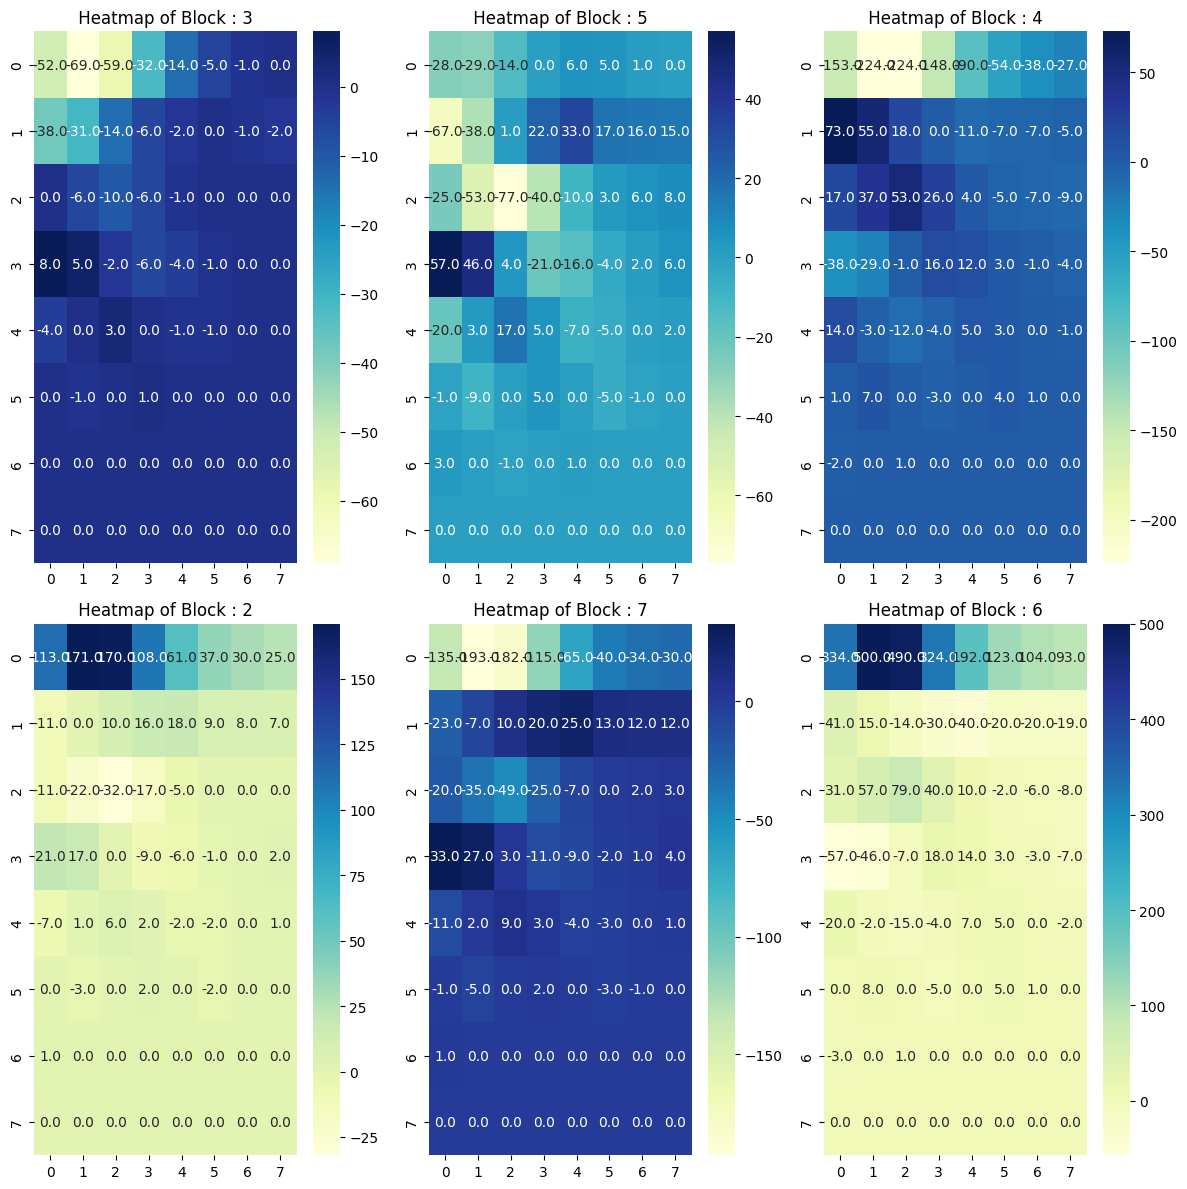

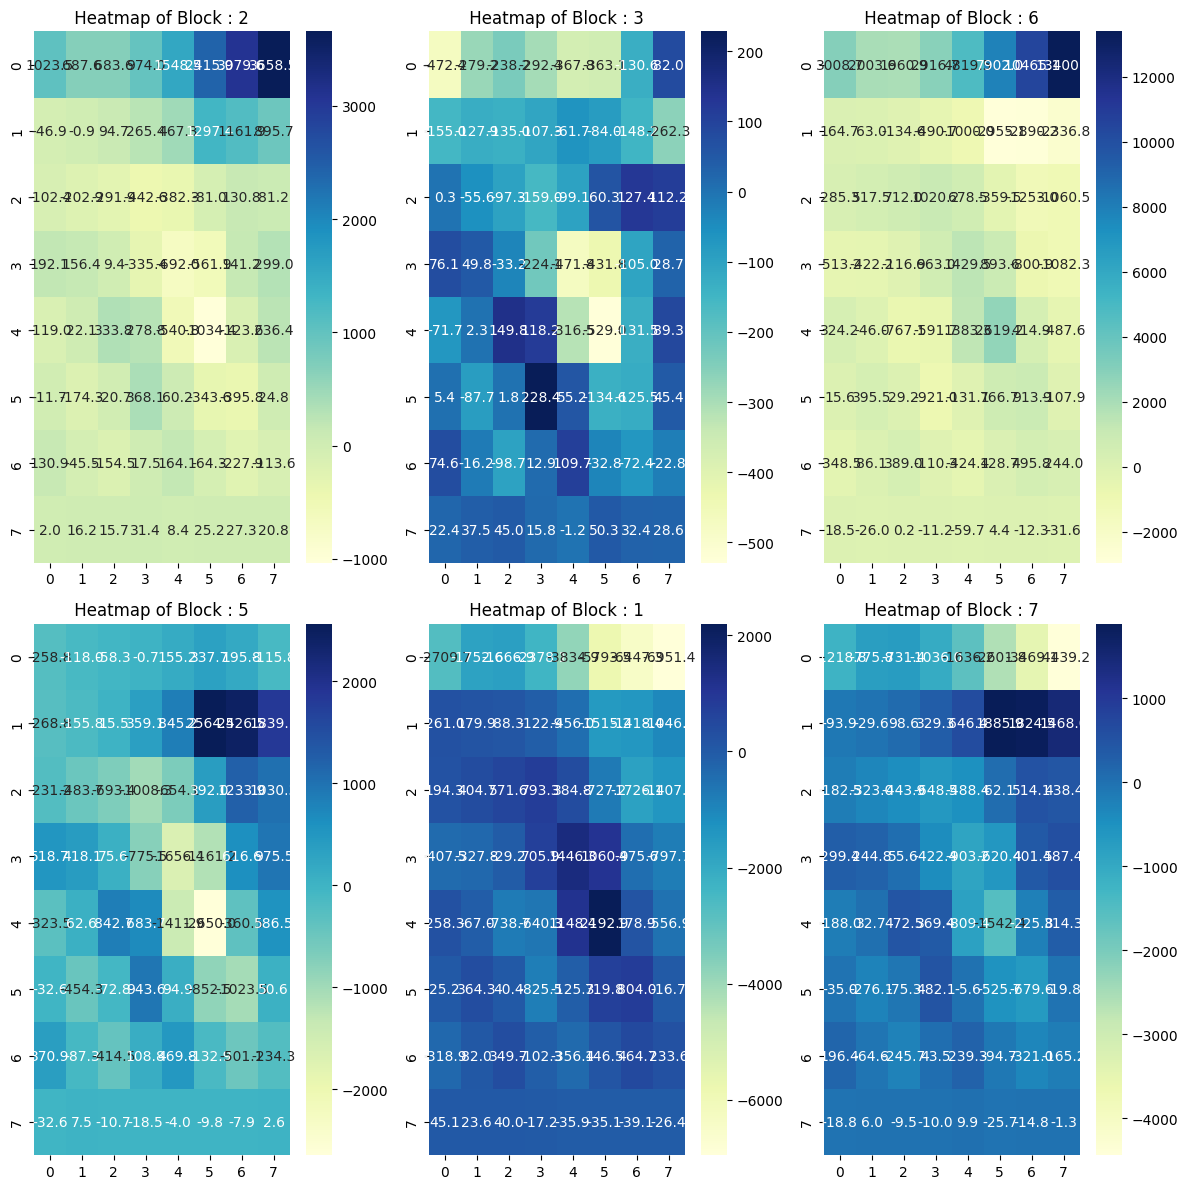

array([2, 3, 6, 5, 1, 7])

In [59]:
chosen_quantize90 = quantization(chosen_dct, quality_levels[90])

dequantization_list90 = list()
for index in chosen_dct:
    dequantization_list90.append(dequantization(index, quality_levels[90]))
chosen_dequantize90 = np.array(dequantization_list90)

random_blocks_heatmap(6, chosen_quantize90)
random_blocks_heatmap(6, chosen_dequantize90)

<div dir="rtl">
عملیات مرحله قبل را با کیفیت 10 انجام دهید.
</div>

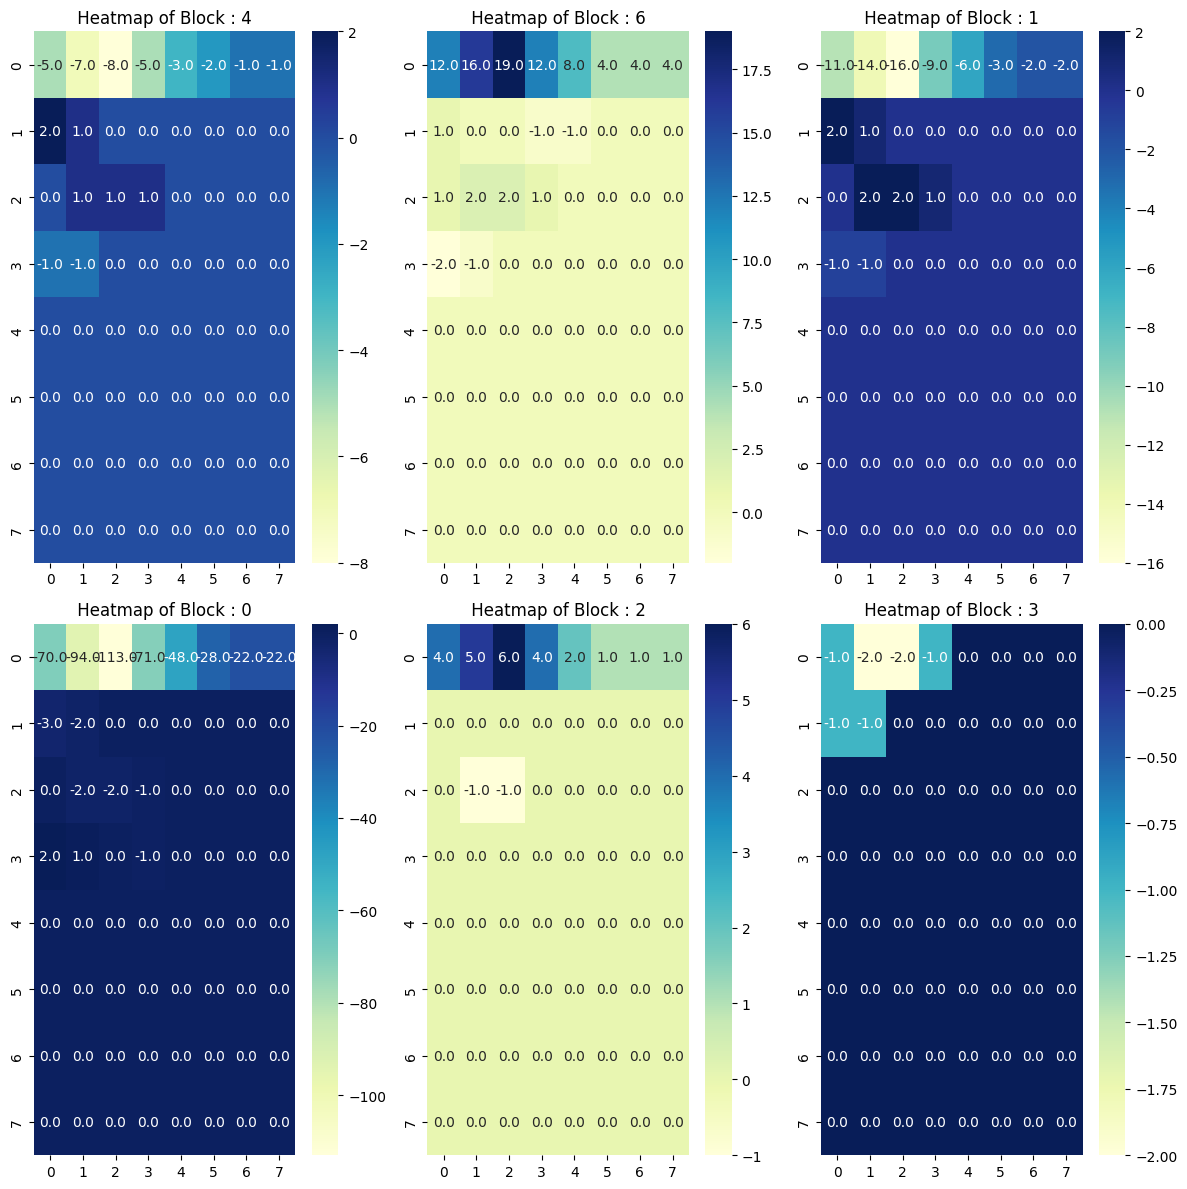

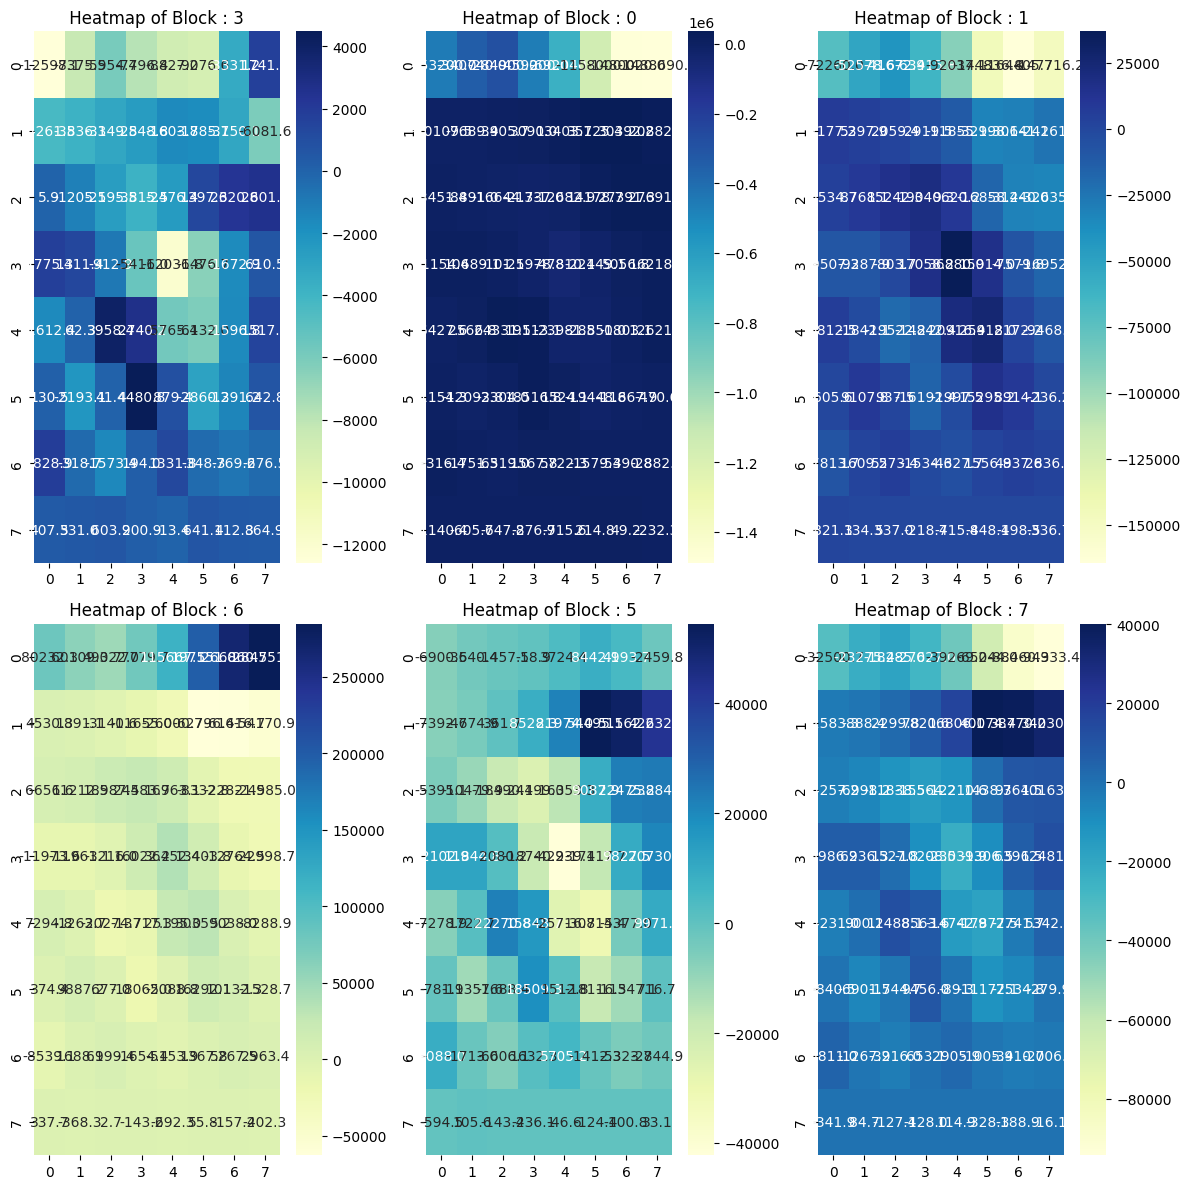

array([3, 0, 1, 6, 5, 7])

In [60]:
chosen_quantize10 = quantization(chosen_dct, quality_levels[10])

dequantization_list10 = list()
for index in chosen_dct:
    dequantization_list10.append(dequantization(index, quality_levels[10]))
chosen_dequantize10 = np.array(dequantization_list10)

random_blocks_heatmap(6, chosen_quantize10)
random_blocks_heatmap(6, chosen_dequantize10)

<div dir="rtl">
مجموع تعداد مولفه های صفر در هر 8x8 را در هر کدام از مراحل بالا حساب کنید. با دیدن این اعداد نتیجه بگیرید که JPEG چگونه عکس ها را فشرده سازی می کند و چرا با فشرده سازی بیشتر، کیفیت پایین می آید.
</div>

your answer

<div dir="rtl">

### سوال دوم:<br>
عکس داده شده را توسط سه کیفیت 10، 50 و 90 به jpeg تبدیل کنید، بازگردانید و فایل های بازگردانده شده را ذخیره کنید.(از فرمت هایی استفاده کنید که خودشان فشرده سازی ندارند)

</div>

In [62]:
jpeg_comp('cat.jpg', 'compress_text_90.txt', 90)
jpeg_comp('cat.jpg', 'compress_text_50.txt', 50)
jpeg_comp('cat.jpg', 'compress_text_10.txt', 10)
compressed_image_90 = jpeg_decomp('compress_text_90.txt', 'compress_img_90.jpeg')
compressed_image_50 = jpeg_decomp('compress_text_50.txt', 'compress_img_50.jpeg')
compressed_image_10 = jpeg_decomp('compress_text_10.txt', 'compress_img_10.jpeg')

<div dir="rtl">

اکنون فایل های بازگردانده شده و فایل اصلی را نمایش دهید، قدرمطلق اختلاف مقدار هر پیکسل از تصاویر بازسازی شده را با پیکسل متناظر در تصویر اصلی پیدا کنید (L1-Norm) و نتیجه را برای سه کیفیت رسم کنید.

</div>

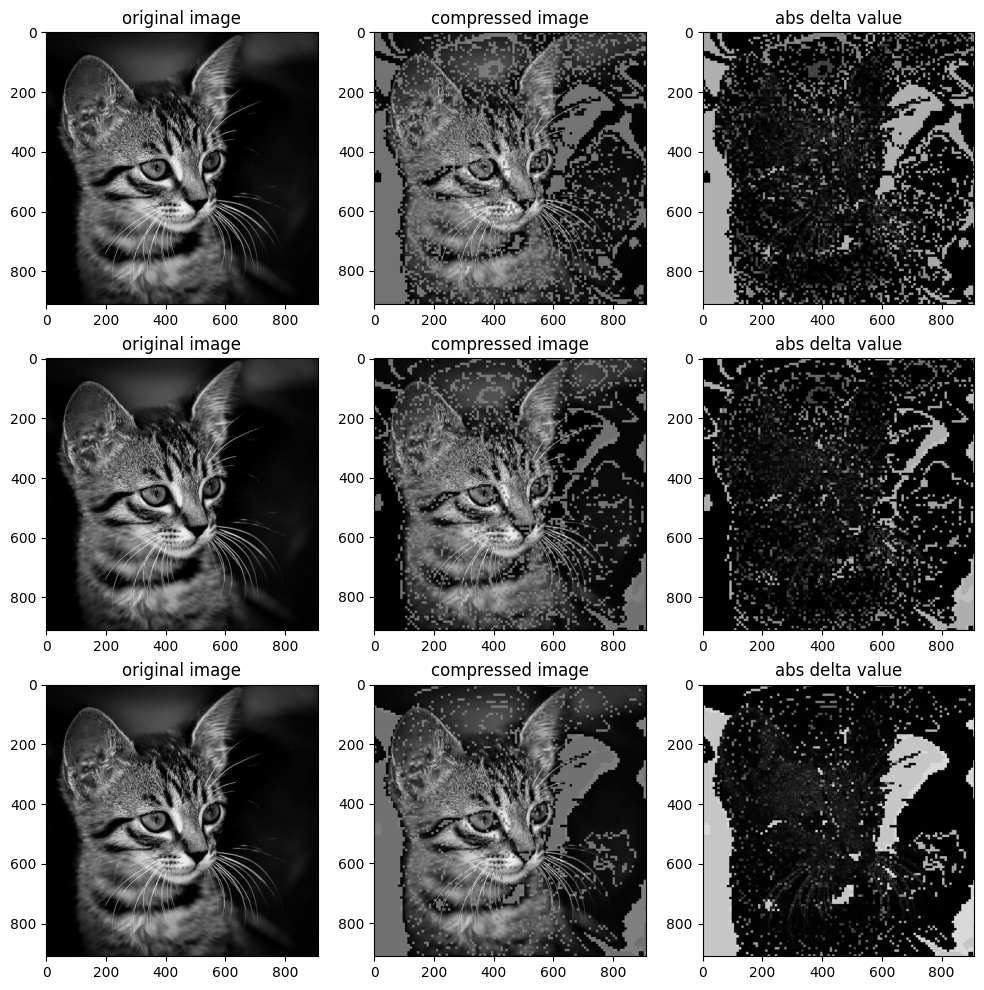

In [65]:
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(3, 3, 1)
plt.title("original image")
plt.imshow(image, cmap='gray')

fig.add_subplot(3, 3, 2)
plt.title("compressed image")
plt.imshow(compressed_image_90, cmap='gray')

fig.add_subplot(3, 3, 3)
plt.title("abs delta value")
plt.imshow(np.abs(image - compressed_image_90[:910, :910]), cmap='gray')

fig.add_subplot(3, 3, 4)
plt.title("original image")
plt.imshow(image, cmap='gray')

fig.add_subplot(3, 3, 5)
plt.title("compressed image")
plt.imshow(compressed_image_50, cmap='gray')

fig.add_subplot(3, 3, 6)
plt.title("abs delta value")
plt.imshow(np.abs(image - compressed_image_50[:910, :910]), cmap='gray')

fig.add_subplot(3, 3, 7)
plt.title("original image")
plt.imshow(image, cmap='gray')

fig.add_subplot(3, 3, 8)
plt.title("compressed image")
plt.imshow(compressed_image_10, cmap='gray')

fig.add_subplot(3, 3, 9)
plt.title("abs delta value")
plt.imshow(np.abs(image - compressed_image_10[:910, :910]), cmap='gray')

<div dir="rtl">

مقدار mean squared error را برای سه کیفیت بدست آورید، سایز فایل های فشرده شده را نیز بنویسید و مقدار سایز فایل ها را بسته به کیفیت آنها با یک رابطه(خطی یا درجه 2) تقریب بزنید. جواب خود را به صورت خلاصه در زیر بنویسید.

</div>

In [71]:
mse90 = np.square(image - compressed_image_90[:910, :910]).mean(axis=None)
print("mse90 :")
print(mse90)
mse50 = np.square(image - compressed_image_50[:910, :910]).mean(axis=None)
print("mse50 :")
print(mse50)
mse10 = np.square(image - compressed_image_10[:910, :910]).mean(axis=None)
print("mse10 :")
print(mse10)

mse90 :
2873.2281631065875
mse50 :
1521.9941407884344
mse10 :
2471.310870785122


your answer

<div dir="rtl">

### سوال سوم:<br>
شما در درس خود DFT را یاد گرفتید. در این سوال می خواهیم ضرایب DFT را به DCT-II تبدیل کنیم تا بیشتر با این تبدیل آشنا شوید.<br>
دنباله اول در زیر را به طول ${n}$ و دنباله ی دوم را به طول ${2n}$ در نظر بگیرید. فرض کنید ضرایب DCT-II دنباله اول برابر با ${d_{k}}$ و ضرایب DFT دنباله دوم برابر با ${c_{k}}$ اند. مقدار ${c_{k}}$ ها را از روی ${d_{k}}$ ها بدست بیاورید.
    $${x_1,x_2,x_3,...,x_n}$$
    $${x_1,x_2,x_3,...,x_n,0,0,...,0}$$
</div>

your answer

## <center>بخش دوم پروژه<br>کار با نویز</center>

<div dir="rtl">

### هدف این بخش:

برای ارسال یک سیگنال از جایی به جای دیگر نیاز به یک کانال داریم. در یک کانال ایده‌آل سیگنال ورودی و خروجی برابر است. همانطور که می دانید در دنیای واقعی کانال ایده‌آل وجود ندارد! سیگنال ها دچار اعوجاج می شوند. روی آنها نویز می افتد و بخشی از آنها از بین می رود. مهندسین برق، کامپیوتر، مکانیک، شیمی و علوم مواد و دانشمندان همواره به دنبال بهتر کردن کانال های ارتباطی هستند.<br> اما می توان این مشکلات را به صورت هوشمندانه دور زد. با دانستن جنس کانال، می توان قبل از ارسال سیگنال، تغییراتی برعکس آنچه در کانال اتفاق می افتد روی سیگنال اعمال کرد، که پس از عبور سیگنال از کانال، حداقل آسیب به سیگنال ما برسد.

</div>

<div dir="rtl">

وظیفه شما این است که برای هر یک از کانال های زیر تابعی طراحی کنید که برعکس کانال عمل کند و با ورودی دادن خروجی تابع شما به کانال، عکس خروجی کانال عکس اولیه باشد. به زبان ساده تر تابع شما تابع معکوس کانال باشد.

</div>

<div dir="rtl">

### ابزار های شما:<br>
شما می توانید به کانال ها ورودی دهید و خروجی را ببینید و در صورتی که نتیجه گیری خاصی کردید آن را با اضافه کردن شکل ورودی و خروجی خود توضیح دهید.<br>
برای دادن ورودی و خروجی کافی است کانال را با python یا python3 اجرا کنید و مسیر به فایل خود را به عنوان آرگومان به آن بدهید.<br>
علاوه بر خود خروجی، شما می توانید تبدیل DCT آن را نیز ببینید و با ورودی مقایسه کنید. در کانال های مخابراتی واقعی رفتار فرکانسی کانال به شدت مهم است و در اینجا نیز با این خصوصیت کانال آشنا خواهید شد. کتابخانه `scipy.fftpack` دارای تبدیل DCT یک بعدی است، با دانش خود از بخش اول پروژه از روی آن تبدیل DCT دوبعدی بسازید و استفاده کنید.<br>


In [ ]:
from scipy.fftpack import dct, idct

<div dir="rtl">
در صورتی که فایل های کامپایل شده اجرا نمی شوند، پایتون خود را به آخرین نسخه (3.11.4) ارتقا دهید و کتابخانه های زیر را روی آن نصب کنید.<br>
<br>
<div dir="ltr">
PIL(using pip: pip install pillow)<br>
SciPy(using pip: pip install scipy)<br>
numpy(using pip: pip install numpy)
</div>
مثال اجرای کد:
</div>
<div dir="ltr">
python "C:\Users\Lenovo\Desktop\channel1.cpython-311.pyc" "C:\Users\Lenovo\Desktop\snapshot.jpg"
</div>
<div dir="rtl">
نکته:<br>
به خاطر داشته باشید که در صورتی که عدد شما در نوشتن یک عکس از بازه (0,255) خارج شود، کتابخانه آن را به پیمانه 256 حساب می کند و در خروجی قرار می دهد. برای جلوگیری از این اتفاق همواره خروجی های خود را با 255 مینیمم و با 0 ماکزیمم بگیرید.
<div>

<div dir="rtl">

### کانال اول:<br>
اگر با گوشی های نسبتا قدیمی زیر نور LED یا مهتابی خانه یا دانشگاه عکس گرفته باشید، متوجه خطوط عمودی، افقی سیاه روشن می شوید. این اتفاق به دلیل کم و زیاد شدن نور LED ها به صورت سینوسی به دلیل سینوسی بودن برق شهر می باشد. اکنون ماهیت کانال را متوجه شده ایم و می خواهیم با انداختن سیگنال معکوسی آن را از بین ببریم. سعی کنید این کار را انجام دهید و نتیجه و کد خود را در زیر بنویسید.
<img src="Items/Channel1_sample2.jpg" alt="Drawing" style="width: 400px;"/><br>
    <center>این نویز در عکس بالا مشهود است، در فیلم برداری و عکس برداری به ترتیب به آن flicker noise و rolling shutter effect می گویند.</center>
<img src="Items/Channel1_sample1.jpg" alt="Drawing" style="width: 400px;"/><br>
    <center>این عکس یکی از تمرینات من زیر نور LED است که باعث مطرح شدن این سوال شد.</center>
<img src="Items/Channel1_sample3.jpg" alt="Drawing" style="width: 400px;"/>
 <br><center>عکس بالا هنگام رعد و برق گرفته شده است، می توان step response دوربین را به این وسیله مشاهده کرد.

In [ ]:
#############  TODO #############
#your code

<div dir="rtl">

غیر ممکن است نه؟ به علت اینکه عرض از مبدا نویز همواره تغییر می کند. پس برای اینکه این نویز را کنسل کنیم باید سیگنال را چندین بار ارسال کنیم و دعا کنیم که در یکی از ارسال ها نویز و تغییرات اضافه ما روی سیگنال همفاز شوند. امید ریاضی تعداد دفعاتی که لازم است سیگنال را ارسال کنیم تا mean square error ما از 2% کمتر شود را حساب کنید.

</div>

In [ ]:
#############  TODO #############
#your code

<div dir="rtl">

### کانال دوم و سوم:<br>
این کانال ها نسبت به رنگ حساس نیستند. برای یافتن اطلاعات بیشتر، ورودی و خروجی کانال را در حوزه فرکانس با هم مقایسه کنید. برای نمایش مقایسه خود می توانید از heatmap استفاده کنید یا اعداد مقایسه شده خود را بر روی یک تصویر نمایش دهید. جواب خود را به صورت کامل در زیر بنویسید.

</div>

your answer

<div dir="rtl">


### سوالات:


</div>

<div dir="rtl">

سوال اول:<br>
یک عکس png با کیفیت و نسبت تصویر HD انتخاب کنید. آن را از کانال اول عبور دهید و mean square error آن را با عکس اولیه بدست آورید. اکنون هم عکس اولیه و هم عکس نویزی را به jpeg تبدیل کنید و دوباره mean square error خود را گزارش کنید. بهتر است از کیفیت ۵۰ برای فشرده‌سازی استفاده کنید.

</div>

your answer

<div dir="rtl">

سوال دوم:<br>
سوال بالا را به ازای کانال دوم تکرار کنید و نتیجه را در زیر بنویسید.

</div>

your answer

<div dir="rtl">

سوال سوم:<br>
سوال بالا را به ازای کانال سوم تکرار کنید و نتیجه را در زیر بنویسید.

</div>

your answer

<div dir="rtl">

سوال چهارم:<br>
با مقایسه نتایج بالا بگویید که خطای باز‌سازی تبدیل jpeg کدام دسته از نویز ها را حذف بیشتر است و کدام دسته را به خوبی بازسازی می‌کند؟.

</div>

your answer


